In [14]:
##################
#
# Uniaxial stretch FEA code
# by M.S.Dimitriyev
# michael.dimitriyev@gmail.com
#
# Uses FEniCS 2019.1.0 as
# packaged in Anaconda
#
##################

from dolfin import *
import numpy as np
import matplotlib.pyplot as plt

In [15]:
# Optimization options for the form compiler
parameters["form_compiler"]["cpp_optimize"] = True
ffc_options = {"optimize": True, \
                  "eliminate_zeros": True, \
                  "precompute_basis_const": True, \
                  "precompute_ip_const": True}

L = 3.0
H = 1.0
Nx = 50
Ny = 50

# Create mesh and define function space
mesh = RectangleMesh(Point(0., 0.), Point(L, H), Nx, Ny, "crossed")
V = VectorFunctionSpace(mesh, "CG", 1)

# Create boundary subdomains
bottom = CompiledSubDomain("near(x[1], side) && on_boundary", side = 0.0)  
top = CompiledSubDomain("near(x[1], side) && on_boundary", side = H)

# Define Dirichlet boundary (y = 0, y = 1)
b = Expression(("0.0", "0.0"),degree=1)
t = Expression(("0.0", "disp"),disp=H,degree=1)

# Assign boundary conditions
bcb = DirichletBC(V, b, bottom)
bct = DirichletBC(V, t, top)
bcs = [bcb, bct]

# Define functions
du = TrialFunction(V)            # Incremental displacement
v  = TestFunction(V)             # Test function
u  = Function(V)                 # Displacement from previous iteration
B  = Constant((0.0, 0.5))  # Body force per unit volume
T  = Constant((0.0, 0.0))  # Traction force on the boundary

# # Kinematics
# I = Identity(len(u))
# F = I + grad(u)             # Deformation gradient
# C = F.T*F                   # Right Cauchy-Green tensor

# # Invariants of deformation tensors
# Ic = tr(C)
# J  = det(F)

# Elasticity parameters
E, nu = 10.0, 0.3
mu, lmbda = Constant(E/(2*(1 + nu))), Constant(E*nu/((1 + nu)*(1 - 2*nu)))

# Define strain
d = u.geometric_dimension()
strain = 0.5*(nabla_grad(u) + nabla_grad(u).T)

# use Voigt notation to enable matrix multiplication for anisotropy
e_vgt = as_vector([strain[0,0],strain[1,1],2*strain[0,1]])


# anisotropic elasticity tensor
e1 = Constant( (1.0, 0.0, 0.0) )
e2 = Constant( (0.0, 1.0, 0.0) )
e3 = Constant( (0.0, 0.0, 1.0) )
c_hook1  = Constant( ( (0.240872, 0.0362245, 0.0), (0.0362245, 0.0599528, 0.0), (0.0, 0.0, 0.01) ) )
alpha_xx = Constant( (1.16995, 0.0, 0.0) )
alpha_yy = Constant( (0.0, 0.802057, 0.0) )
beta_xx  = Constant( (0.0223765, 0.0, 0.0) )
beta_yy  = Constant( (0.0, 0.0219965, 0.0) )	


# Stored strain energy density
psi = .5*dot(e_vgt,c_hook1*e_vgt) 
psi += dot(e1,beta_xx)*( pow(dot(e1,alpha_xx),2)*pow(dot(e1,e_vgt),3) + pow(dot(e1,alpha_xx),3)*pow(dot(e1,e_vgt),4) )
psi += dot(e2,beta_yy)*( pow(dot(e2,alpha_yy),2)*pow(dot(e2,e_vgt),3) + pow(dot(e2,alpha_yy),3)*pow(dot(e2,e_vgt),4) )

# Total potential energy
Pi = psi*dx - dot(B, u)*dx - dot(T, u)*ds

# Compute first variation of Pi (directional derivative about u in the direction of v)
F = derivative(Pi, u, v)

# Compute Jacobian of F
J = derivative(F, u, du)

# Solve variational problem
solve(F == 0, u, bcs, J=J,
      form_compiler_parameters=ffc_options,
      solver_parameters={
      "newton_solver":{"relative_tolerance":1E-12},
      "newton_solver":{"maximum_iterations":100}})

# Save solution in VTK format
file = File("displacement.pvd");
file << u;

Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 2.818e+01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 5.615e-01 (tol = 1.000e-10) r (rel) = 1.993e-02 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 2.143e-01 (tol = 1.000e-10) r (rel) = 7.603e-03 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 1.538e-01 (tol = 1.000e-10) r (rel) = 5.459e-03 (tol = 1.000e-09)
  Newton iteration 4: r (abs) = 5.158e-02 (tol = 1.000e-10) r (rel) = 1.830e-03 (tol = 1.000e-09)
  Newton iteration 5: r (abs) = 1.080e-02 (tol = 1.000e-10) r (rel) = 3.832e-04 (tol = 1.000e-09)
  Newton iteration 6: r (abs) = 8.182e-04 (tol = 1.000e-10) r (rel) = 2.903e-05 (tol = 1.000e-09)
  Newton iteration 7: r (abs) = 7.148e-06 (tol = 1.000e-10) r (rel) = 2.537e-07 (tol = 1.000e-09)
  Newton iteration 8: r (abs) = 9.378e-10 (tol = 1.000e-10) r (rel) = 3.328e-11 (tol = 1.000e-09)
  Newton solver finished in 8 iterations and 8 linear solver iterations.


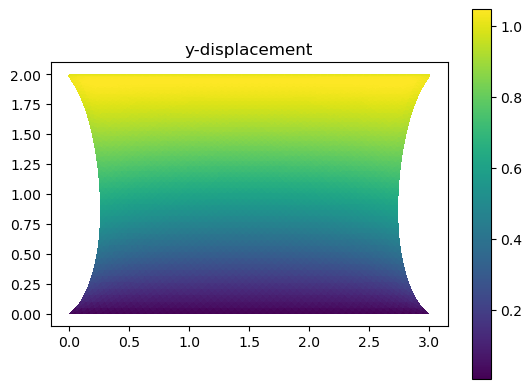

In [16]:
plt.figure()
p1 = plot(u, title='y-displacement', mode='displacement')
plt.colorbar(p1)
plt.show()

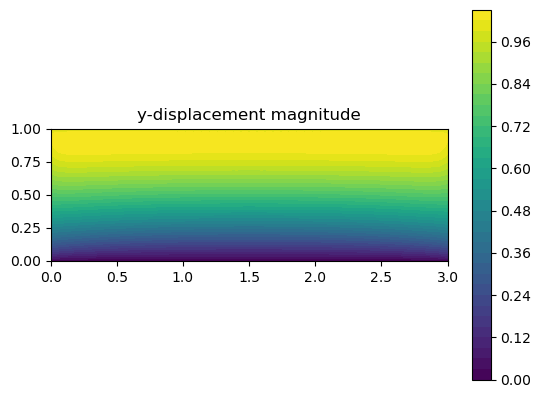

In [17]:
V2 = FunctionSpace(mesh, 'P', 1)

# Compute magnitude of displacement
u_magnitude = sqrt(dot(u, u))
u_magnitude = project(u_magnitude, V2)
plt.figure()
p2 = plot(u_magnitude, title='y-displacement magnitude')
plt.colorbar(p2)
plt.show()

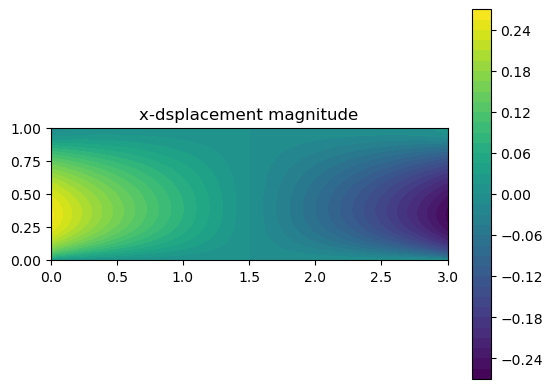

In [18]:
plt.figure()
p3 = plot(u.sub(0), title='x-dsplacement magnitude')
plt.colorbar(p3)
plt.show()